In [1]:
import glob
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, OneHotEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from ALLCools.mcds import MCDS
from ALLCools.plot import *
from ALLCools.clustering import *
from wmb import brain, aibs, broad, mm10
import pynndescent


In [ ]:
aibs_annot = aibs.get_tenx_annot()
aibs_annot

In [3]:
annot = aibs_annot[['L1', 'L2', 'L3', 'L1_annot', 'L2_annot', 'DissectionRegion', 'SubRegion', 'MajorRegion']].to_pandas()

In [4]:
NN_types = ['NN', 'IMN']
nonoverlap_types = np.concatenate([annot['L2_annot'][annot['L2_annot'].str.startswith('CB')].unique(),
                                   annot['L2_annot'][annot['L2_annot'].str.startswith('DCO')].unique(),
                                   annot['L2_annot'][annot['L2_annot'].str.startswith('MM')].unique(),
                                  ])


In [3]:
rna_region_dict = {
    'CTX': ["RSP", "ACA","PL-ILA-ORB", "AI-CLA", "AId-AIv", "AId-AIv-AIp", "TEa-PERI-ECT", "AUD-TEa-PERI-ECT", "AUD", "PTLp", "VIS", "VIS-PTLp", "VISl", 'VISm', 'VISp', "MOp", "MOs-FRP", "MO-FRP", "SSp", "SSs-GU-VISC-AIp", "SS-GU-VISC"],
    'HIP': ["HIP", "HIP - CA"],
    'OLF': ["OLF - MOB-AOB", "OLF - AON-TT-DP"],
    'RHP': ["PAR-POST-PRE-SUB-ProS", 'ENT'],
    'PIR': ["OLF - COA-PAA-NLOT-TR","OLF - PIR", "OLF - AON-TT-DP-PIR-COA-NLOT-PAA-TR", 'CTXsp - CLA-EP-LA-BLA-BMA-PA'],
    'AMY': ["STR - sAMY"],
    'STR': ["STR - STRd", "STR - STRv"],
    'PAL': ["CNU - PAL"],
    'TH': ["TH - Middle-lateral", "TH - LGd-IGL-LGv", "TH - Posterior", "TH - Anterior", "TH - PVT-PT", "TH - MG-SPFp-PP-POL-SGN-PoT-PIL", "TH - PO-Eth", "TH - PF-SPA-SPFm-VPMpc-VPLpc-RT", "TH", "TH - MH-LH-LP","TH - Middle-medial", "TH - AD-AV-AM-IAD-LD", "TH - RE-RH-CM-IAM-SMT-PR-Xi", "TH - MD-IMD-PCN-CL", "TH - VAL-VPM-VPL-VM"], 
    'HY': ["HY - HYa1", "HY - HYa2", "HY - HYm2", "HY - HYml", "HY - HYmm", "HY - HYpl", "HY - HYpm", "HY - MEZ-PVZ-PVR", "HY LZ"], 
    'MB': ["MB - VTA-SN", "MB - IC", "MB - MRN-CUN-RN-RR-PPN-PRT-SC-IC","MB - SC-IC",'MB - SC',"MB - MRN-CUN-RN-RR-PN", "MB - MRN-CUN-RN-RR-PPN-NB-SAG-PBG", "MB - MRN-CUN-RN-RR-PPN-PRT", "MB - PAG-RAmb", 'MB - PRT'], 
    'HB': ["MY - AP-DCO-VCO-DCN-ECU-NTS", "MY - CN-DCN-ECU-NTS-SPVC-SPVI-SPVO", "MY - MYsat-MYmot", "MY - MYsat-MYmot ant", "MY - MYsat-MYmot post", "MY - MYsat-MYmot-vent post", "MY - MYsat-Mymot-vent ant", "MY - SPVC-SPVI-SPVO", "MY - VNC-PHY-DMX-XII","HB - MY", "PONS - Pmot-Psat ant", "PONS - Pmot-Psat post", "PONS - Psen"]
}


In [2]:
# Parameters
group_name = 'TH'


In [4]:
t = group_name
selregion = rna_region_dict[t]


In [8]:
# select all CB cells
selc = annot.loc[annot['DissectionRegion'].isin(selregion) & (~annot['L1_annot'].isin(NN_types)) & (~annot['L2_annot'].isin(nonoverlap_types))].index
len(selc)

162795

In [9]:
rnads_path = aibs.AIBS_TENX_V2_ZARR_PATH
rna_ds = MCDS.open(rnads_path, use_obs=selc, var_dim='gene')
rna_ds

<xarray.MCDS>
Dimensions:     (cell: 162795, gene: 32285)
Coordinates:
  * cell        (cell) <U37 'L8TX_200716_01_A07-GCTTTCGCACAGAAGC-1' ... 'L8TX...
  * gene        (gene) <U18 'ENSMUSG00000051951' ... 'ENSMUSG00000095041'
    gene_count  (cell) float32 6.465e+03 6.072e+03 ... 2.789e+03 3.315e+03
    gene_name   (gene) <U16 'Xkr4' 'Gm1992' ... 'AC234645.1' 'AC149090.1'
    umi_count   (cell) float32 2.412e+04 2.153e+04 ... 5.561e+03 9.279e+03
Data variables:
    gene_da     (cell, gene) float32 dask.array<chunksize=(5000, 32285), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  gene

In [10]:
retro = anndata.read_h5ad('cell_1972_retro_TH.h5ad')
retro

AnnData object with n_obs × n_vars = 1972 × 36679
    obs: 'well', 'plate', 'i7_barcode_name', 'cell_barcode', 'Projection', 'animal_id', 'animal_age', 'animal_sex', 'date_sort', 'date_cDNA', 'date_lib', 'total_UMI', 'genes_detected', 'is_ODC', 'cluster', 'joint_cluster', 'file_name_barcode', 'file_name_mRNA'

In [11]:
from scipy.sparse import csr_matrix
retro.X = csr_matrix(retro.X)


In [12]:
retro.X.data = retro.X.data/np.repeat(retro.obs['total_UMI'].values, retro.X.getnnz(axis=1)
                                     ) * retro.obs['total_UMI'].median()
sc.pp.log1p(retro)

In [13]:
# cef = pd.read_csv(f'{t}_mC_CEF.txt', header=None, index_col=0).index
# cef.name = 'gene'
# cef

In [19]:
# use_genes = rna_ds.get_index('gene').isin(cef)
# use_genes.sum()

7887

In [14]:
use_genes = rna_ds['gene_name'].to_pandas().isin(retro.var.index)# & use_genes
use_genes.sum()

24237

In [15]:
adata = rna_ds.get_count_adata(da_name='gene_da', use_vars=use_genes.values)
adata

Loading chunk 0-10000/162795
Loading chunk 10000-20000/162795
Loading chunk 20000-30000/162795
Loading chunk 30000-40000/162795
Loading chunk 40000-50000/162795
Loading chunk 50000-60000/162795
Loading chunk 60000-70000/162795
Loading chunk 70000-80000/162795
Loading chunk 80000-90000/162795
Loading chunk 90000-100000/162795
Loading chunk 100000-110000/162795
Loading chunk 110000-120000/162795
Loading chunk 120000-130000/162795
Loading chunk 130000-140000/162795
Loading chunk 140000-150000/162795
Loading chunk 150000-160000/162795
Loading chunk 160000-162795/162795


AnnData object with n_obs × n_vars = 162795 × 24237
    obs: 'count', 'umi_count'
    var: 'name'

In [16]:
# same as sc.pp.normalize_per_cell(adata) but this method only normalize to 
# total read counts of the remaining CEF 
# instead of all the gene counts as saved in umi_count

adata.X.data = adata.X.data/np.repeat(adata.obs['umi_count'].values, adata.X.getnnz(axis=1)
                                     ) * adata.obs['umi_count'].mean()


In [18]:
sc.pp.log1p(adata)
#sc.pp.scale(adata) this method is supposed to use large memory so skip this 

In [19]:
adata.var['mean'] = adata.X.mean(axis=0).A1
adata.var['std'] = (adata.X.multiply(adata.X)).mean(axis=0).A1 - (adata.var['mean'].values ** 2)
adata.raw = adata.copy()
print(adata.var['std'].min())


0.0


In [18]:
adata.obs[annot.columns] = annot.loc[adata.obs.index,:]
adata

AnnData object with n_obs × n_vars = 162795 × 24237
    obs: 'count', 'umi_count', 'L1', 'L2', 'L3', 'L1_annot', 'L2_annot', 'DissectionRegion', 'SubRegion', 'MajorRegion'
    var: 'name', 'mean', 'std'
    uns: 'log1p'

In [19]:
pass_std_filter = (adata.var['std'].values > 0.005)
adata._inplace_subset_var(pass_std_filter)


In [20]:
from ALLCools.clustering import cluster_enriched_features
cluster_enriched_features(adata, 'L3', top_n=200, alpha=0.05, stat_plot=False, method="rna")


Found 1128 clusters to compute feature enrichment score
Computing enrichment score
Computing enrichment score FDR-corrected P values
Selected 5404 unique features


In [22]:
adata.var['L3_enriched_features'].sum()

5404

In [23]:
adata = adata[:, adata.var['L3_enriched_features']].copy()
adata.write_h5ad(f'{t}_{adata.shape[0]}_rna.h5ad')


In [12]:
adata = anndata.read_h5ad(glob.glob(f'{t}_*_rna.h5ad')[0])
retro = anndata.read_h5ad(glob.glob(f'{t}_*_retro.h5ad')[0])

In [13]:
retro = retro[:, adata.var['name'].values.astype(str)].copy()
retro.var.index = adata.var.index
retro

In [17]:
ref_adata = adata
qry_adata = retro

In [26]:
np.random.seed(0)

n_train_cell = 100000
# select mC cells to fit the model
train_cell = np.zeros(ref_adata.shape[0]).astype(bool)
if ref_adata.shape[0] > n_train_cell:
    train_cell[np.random.choice(np.arange(ref_adata.shape[0]), n_train_cell,
                                False)] = True
else:
    train_cell[:] = True

ref_adata.obs['Train'] = train_cell.copy()
ref_adata.obs['Train'].sum()


100000

In [13]:
def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f"{name}_{i}"] = adata.obsm[f"X_{name}"][:, i]
    return adata

In [29]:
if (ref_adata.obs['Train'].sum() >= 100) and (ref_adata.shape[1]>=100):
    #model = PCA(n_components=100, svd_solver='arpack', random_state=0)
    #TruncatedSVD is for sparse matrices whereas PCA is for normal matrices and will center data
    # defore SVD
    model = TruncatedSVD(n_components=100, algorithm='arpack', random_state=0) 
else:
    model = TruncatedSVD(n_components=ref_adata.X[ref_adata.obs['Train'].values].shape[1]-1, svd_solver='arpack', random_state=0)
    #model = PCA(n_components=ref_adata.X[ref_adata.obs['Train'].values].shape[1]-1, svd_solver='arpack', random_state=0)

# use selected mC cells to fit
model.fit(ref_adata.X[ref_adata.obs['Train'].values])
sel_dim = (model.singular_values_ != 0)
print(sel_dim.sum())

100


In [30]:
## Transform RS1

chunk_size = 50000
chunks = []
for chunk_start in range(0, ref_adata.shape[0], chunk_size):
    chunks.append(
        model.transform(ref_adata.X[chunk_start:(chunk_start + chunk_size)]))

ref_adata.obsm['cef_pca'] = np.concatenate(chunks, axis=0)[:, sel_dim]
ref_adata.obsm['cef_pca'] /= model.singular_values_[sel_dim]


In [14]:
ncc = significant_pc_test(ref_adata, p_cutoff=0.1, update=False, obsm='cef_pca')
npc = min([ncc+10, 50])

Downsample PC matrix to 50000 cells to calculate significant PC components
47 components passed P cutoff of 0.1.


In [32]:
ref_adata.write_h5ad(f'{t}_{ref_adata.shape[0]}_rna.h5ad')


In [33]:
## Transform RS2

# qry_adata = anndata.read_h5ad(glob.glob(f'{t}_*_rs2_mch.h5ad')[0])
chunks = []
for chunk_start in range(0, qry_adata.shape[0], chunk_size):
    chunks.append(
        model.transform(qry_adata.X[chunk_start:(chunk_start + chunk_size)]))

qry_adata.obsm['cef_pca'] = np.concatenate(chunks, axis=0)[:, sel_dim]
qry_adata.obsm['cef_pca'] /= model.singular_values_[sel_dim]


In [34]:
qry_adata.write_h5ad(f'{t}_{qry_adata.shape[0]}_retro.h5ad')


In [15]:
from ALLCools.integration.seurat_class import SeuratIntegration

integrator = SeuratIntegration()

In [16]:
qry_adata.obs["Study"] = "RetroSeq"
ref_adata.obs["Study"] = "AIBS_10x"


In [17]:
adata_list = [ref_adata, qry_adata]
for xx in adata_list:
    xx.obsm['X_pca'] = normalize(xx.obsm['cef_pca'][:, :npc], axis=1)

adata_list

[AnnData object with n_obs × n_vars = 162795 × 5404
     obs: 'count', 'umi_count', 'L1', 'L2', 'L3', 'L1_annot', 'L2_annot', 'DissectionRegion', 'SubRegion', 'MajorRegion', 'Train', 'Study'
     var: 'name', 'mean', 'std', 'L3_enriched_features'
     uns: 'L3_feature_enrichment', 'log1p'
     obsm: 'cef_pca', 'X_pca',
 AnnData object with n_obs × n_vars = 1972 × 5404
     obs: 'well', 'plate', 'i7_barcode_name', 'cell_barcode', 'Projection', 'animal_id', 'animal_age', 'animal_sex', 'date_sort', 'date_cDNA', 'date_lib', 'total_UMI', 'genes_detected', 'is_ODC', 'cluster', 'joint_cluster', 'file_name_barcode', 'file_name_mRNA', 'Study'
     uns: 'log1p'
     obsm: 'cef_pca', 'X_pca']

In [33]:
import time
start_time = time.time()
#(adata_list, key_anchor='X', mode='rpca', dimred='pca', max_cc_cell=20000, 
# klocal=False, kfilter=False, scale1=False, scale2=False, ncc=30, alignments=[[[0],[1]]])
anchor = integrator.find_anchor(adata_list,
                                k_local=None,
                                key_local='X_pca',
                                k_anchor=25,
                                key_anchor='X',
                                dim_red='rpca',
                                max_cc_cells=100000,
                                k_score=30,
                                scale1=False,
                                scale2=False,
                                n_components=npc,
                                n_features=200,
                                alignments=[[[0], [1]]])
print(time.time() - start_time)


Find anchors across datasets.
Run rPCA
Score Anchors
Identified 11005 anchors between datasets 0 and 1.
73.87191724777222


In [18]:
# scale =[False, True] as a list
anchor = integrator.find_anchor(adata_list,
                                k_local=None,
                                key_local='X_pca',
                                k_anchor=5,
                                key_anchor='X',
                                dim_red='cca',
                                max_cc_cells=50000,
                                k_score=30,
                                k_filter=200,
                                scale1=True,
                                scale2=True,
                                #scale =[False, True]
                                n_components=ncc,
                                n_features=200,
                                alignments=[[[0], [1]]])


Find anchors across datasets.
Run CCA
non zero dims 47
Find Anchors using k=30
Anchor selected with high CC feature graph: 785 / 8996
Score Anchors
Identified 785 anchors between datasets 0 and 1.


In [19]:
import time
start_time = time.time()
corrected = integrator.integrate(key_correct='X_pca',
                                 row_normalize=True,
                                 n_components=npc,
                                 k_weight=100,
                                 sd=1,
                                 alignments=[[[0], [1]]])

print(time.time() - start_time)


Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data
3.6430277824401855


In [20]:
qry_adata.obsm['X_pca_corrected'] = normalize(corrected[1], axis=1)
qry_adata.write_h5ad(f'{t}_{qry_adata.shape[0]}_retro.h5ad')


In [21]:
integrator.save(f'{t}_integration_rna_retro')


In [22]:
ncell = ref_adata.shape[0] + qry_adata.shape[0]
adata_merge = anndata.AnnData(
    X=np.ones((ncell, 1)), obs=pd.concat([ref_adata.obs, qry_adata.obs], axis=0)
)

In [23]:
adata_merge.obsm["X_pca_corrected"] = np.concatenate(corrected, axis=0)

In [24]:
start_time = time.time()
tsne(
    adata_merge,
    obsm="X_pca_corrected",
    metric="euclidean",
    exaggeration=-1,
    perplexity=50,
    n_jobs=-1,
)
dump_embedding(adata_merge, "tsne")
adata_merge.obsm[f"u{npc}seurat_tsne"] = adata_merge.obsm["X_tsne"].copy()
print(time.time() - start_time)


196.96190285682678


In [35]:
adata_merge.obs.loc[:, adata_merge.obs.dtypes == "object"] = adata_merge.obs.loc[
    :, adata_merge.obs.dtypes == "object"
].astype(str)
adata_merge.write_h5ad(f'{t}_{adata_merge.shape[0]}_rnaretro.h5ad')


In [27]:
aibs_cell = (adata_merge.obs['Study']=='AIBS_10x')
retro_cell = (adata_merge.obs['Study']=='RetroSeq')
print(aibs_cell.sum(), retro_cell.sum())


162795 1972


In [29]:
sd = 1
start_time = time.time()
index = pynndescent.NNDescent(adata_merge.obsm['X_pca_corrected'][aibs_cell], metric='euclidean', n_neighbors=min(50, aibs_cell.sum()), random_state=0, n_jobs=-1)
print(time.time() - start_time)
G, D = index.query(adata_merge.obsm['X_pca_corrected'][retro_cell], k=min(25, aibs_cell.sum()))
print(time.time() - start_time)
np.savez('Retro_AIBS10xNN.npz', G=G, D=D, aibs_cell=adata_merge.obs.index[aibs_cell], merfish_cell=adata_merge.obs.index[retro_cell])


29.00930953025818
40.94072890281677


In [9]:
G = np.load('Retro_AIBS10xNN.npz', allow_pickle=True)['G'][:, :5]
D = np.load('Retro_AIBS10xNN.npz', allow_pickle=True)['D'][:, :5]
aibs_cell = np.load('Retro_AIBS10xNN.npz', allow_pickle=True)['aibs_cell']
retro_cell = np.load('Retro_AIBS10xNN.npz', allow_pickle=True)['merfish_cell']


In [10]:
import time
chunk_size = 50000
sd = 1
start_time = time.time()
cellfilter = D[:, -1] == 0
D = 1 - D / D[:, -1][:, None]
D[cellfilter] = 1
D = 1 - np.exp(-D * (sd**2) / 4)
D = D / (np.sum(D, axis=1) + 1e-6)[:, None]
print(time.time() - start_time)


0.0009138584136962891


In [8]:
coord_base = 'tsne'
ds = 0.1

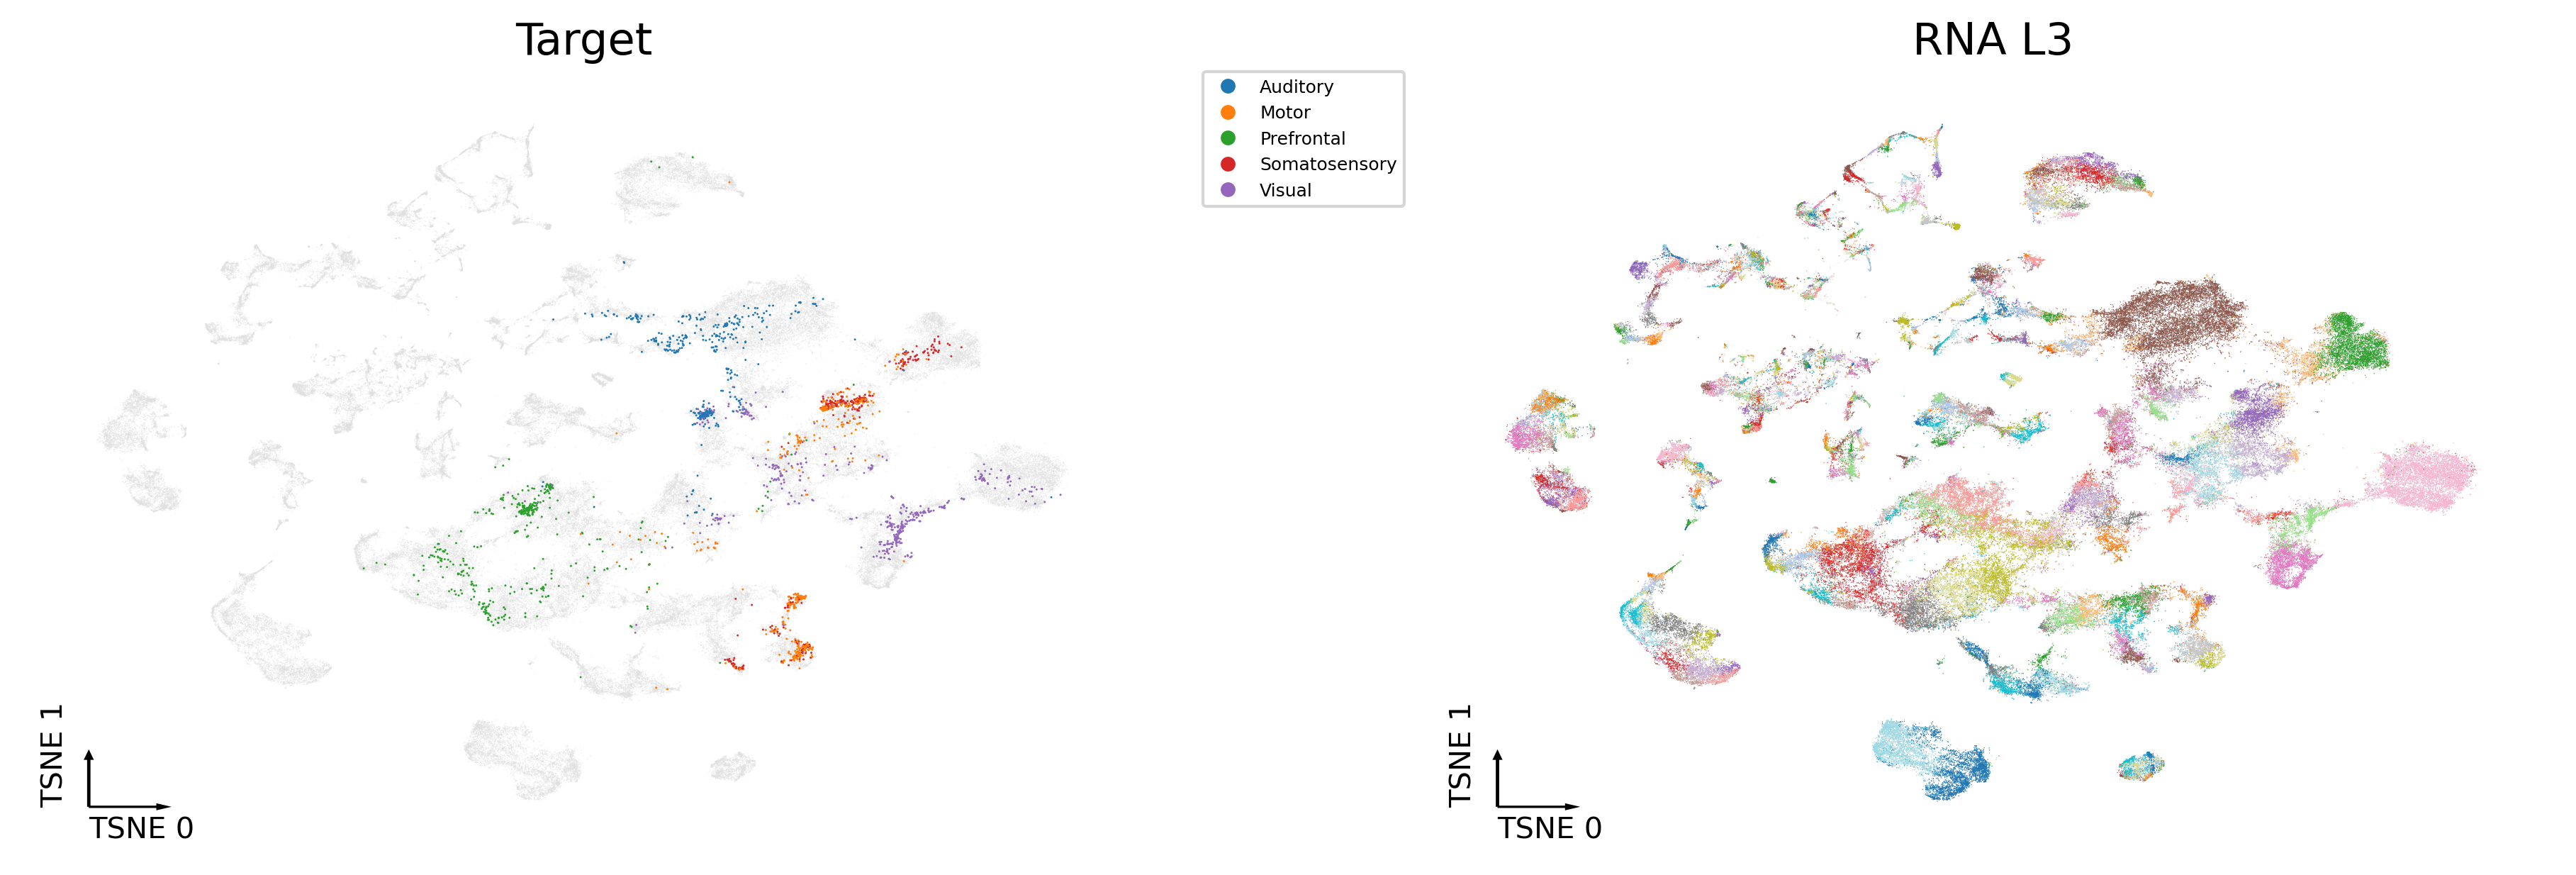

In [32]:
# cca anchor filter

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=300, constrained_layout=True)
ax = axes.flatten()

tmp = adata_merge.obs.loc[adata_merge.obs["Study"] == "RetroSeq"]
ax[0].scatter(
    adata_merge.obs[f"{coord_base}_0"],
    adata_merge.obs[f"{coord_base}_1"],
    c="#e0e0e0",
    edgecolors="none",
    s=ds,
    alpha=0.5,
    rasterized=True,
)
_ = categorical_scatter(
    data=tmp,
    ax=ax[0],
    coord_base=coord_base,
    s=ds * 5,
    hue="Projection",
    # text_anno="L1_annot",
    palette="tab10",
    labelsize=10,
    max_points=None,
    scatter_kws={"rasterized": True},
    show_legend=True,
    outline=None,
    legend_kws = {'ncol':1, 'fontsize':6}
)

tmp = adata_merge.obs.loc[adata_merge.obs["Study"] == "AIBS_10x"]
count = tmp["L2_annot"].value_counts()
count = count[count > (tmp.shape[0] * 0.0005)]
tmp = tmp[tmp["L2_annot"].isin(count.index)]
ax[1].scatter(
    adata_merge.obs[f"{coord_base}_0"],
    adata_merge.obs[f"{coord_base}_1"],
    c="#e0e0e0",
    edgecolors="none",
    s=ds,
    alpha=0.5,
    rasterized=True,
)
_ = categorical_scatter(
    data=tmp,
    ax=ax[1],
    coord_base=coord_base,
    s=ds,
    hue="L3",
    # text_anno='L2_annot',
    palette="tab20",
    labelsize=10,
    max_points=None,
    scatter_kws={"rasterized": True},
    # show_legend=True,
    # legend_kws = {'ncol':2, 'fontsize':4}
)
for i, xx in enumerate(["Target", "RNA L3"]):
    axes.flatten()[i].set_title(xx, fontsize=15)

# plt.savefig(f'cell_{adata_merge.shape[0]}_{t}_AIBS10x_CEMBAsnmC_CEMBAEpiRetro.CEMBAL1_AIBSL2.pdf', transparent=True)


In [14]:
adata_merge = anndata.read_h5ad('TH_182344_rs1rs2rna.h5ad')
adata_merge

AnnData object with n_obs × n_vars = 182344 × 1
    obs: 'mCCCFrac', 'mCGFrac', 'mCHFrac', 'FinalmCReads', 'DissectionRegion', 'Plate', 'Col384', 'Row384', 'Slice', 'Sample', 'Technology', 'InputReads', 'PassBasicQC', 'PlateNormCov', 'CEMBARegion', 'MajorRegion', 'SubRegion', 'L1', 'L1_annot', 'L4', 'L4Region', 'L2_annot', 'Train', 'Study', 'Exp', 'Source', 'Target', 'Gender', 'L2', 'L3', 'PlateNormReads', 'count', 'umi_count', 'tsne_0', 'tsne_1', 'leiden'
    uns: 'leiden', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'u50seurat_tsne'
    obsp: 'connectivities', 'distances'

In [33]:
aibs_cell = (adata_merge.obs['Study']=='AIBS_10x')

In [15]:
for xx in ['leiden', 'leiden_score', 'tsne_0', 'tsne_1']:
    qry_adata.obs[xx] = ''


In [22]:
enc = OneHotEncoder()
labelref = enc.fit_transform(adata_merge.obs.loc[aibs_cell, 'leiden'].astype(str)[:, None])
start_time = time.time()
for chunk_start in range(0, retro.shape[0], chunk_size):
    tmp = (
        D[chunk_start : (chunk_start + chunk_size), :, None]
        * labelref[G[chunk_start : (chunk_start + chunk_size)].flatten()]
        .toarray()
        .reshape((-1, min(5, aibs_cell.shape[0]), enc.categories_[0].shape[0]))
    ).sum(axis=1)
    tmp = pd.DataFrame(
        tmp,
        columns=enc.categories_[0],
        index=qry_adata.obs.index[chunk_start : (chunk_start + chunk_size)],
    )
    qry_adata.obs.loc[tmp.index, 'leiden'] = tmp.idxmax(axis=1).values
    qry_adata.obs.loc[tmp.index, "leiden_score"] = tmp.max(axis=1).values
    print(chunk_start)

print(time.time() - start_time)


0
0.007981538772583008


In [23]:
continuous_label = ['tsne_0', 'tsne_1']
labelref = adata_merge.obs.loc[aibs_cell, continuous_label].values
start_time = time.time()
for chunk_start in range(0, retro.shape[0], chunk_size):
    selc = retro.obs.index[chunk_start : (chunk_start + chunk_size)]
    tmp = (
        D[chunk_start : (chunk_start + chunk_size), :, None]
        * labelref[G[chunk_start : (chunk_start + chunk_size)]]
    ).sum(axis=1)
    qry_adata.obs.loc[selc, continuous_label] = tmp.copy()
    print(chunk_start)

print(time.time() - start_time)


0
0.002811908721923828


In [24]:
qry_adata.obs[['leiden_score', 'tsne_0', 'tsne_1']] = qry_adata.obs[['leiden_score', 'tsne_0', 'tsne_1']].astype(float)

In [25]:
qry_adata.write_h5ad(f'{t}_{qry_adata.shape[0]}_retro_new.h5ad')
